<a href="https://colab.research.google.com/github/cnarte/Bert-notebooks/blob/master/Bert%20Immplementation%20using%20colab/jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bert Immplementation using colab/jupyter using Pytorch
<p>For the explanation of how to use bert, we will make a binary classifier of given data I have selected a dataset from a real-world competition on jantahack, that has abstracts of research papers and we predict if it is of computer science field(my field :). Data set is uploaded in repo.

# Install Transformers Library

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify gpu/cpu as per your choice ((Check out readme for installing cuda for supported devices))
device = torch.device("cpu")

# Load Dataset and morph Data.
<P>The data we have imported is actually of multilabel form, but we are going to predict only one label to keep it simple.


In [ ]:
df = pd.read_csv("/content/drive/My Drive/data/train.csv")
#droping unwanted labels and id
df=df.drop(columns={'ID','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance'},axis=1)


In [ ]:
df.describe

<bound method NDFrame.describe of                                                    TITLE  ... Computer Science
0            Reconstructing Subject-Specific Effect Maps  ...                1
1                     Rotation Invariance Neural Network  ...                1
2      Spherical polyharmonics and Poisson kernels fo...  ...                0
3      A finite element approximation for the stochas...  ...                0
4      Comparative study of Discrete Wavelet Transfor...  ...                1
...                                                  ...  ...              ...
20967  Contemporary machine learning: a guide for pra...  ...                1
20968  Uniform diamond coatings on WC-Co hard alloy c...  ...                0
20969  Analysing Soccer Games with Clustering and Con...  ...                1
20970  On the Efficient Simulation of the Left-Tail o...  ...                0
20971   Why optional stopping is a problem for Bayesians  ...                0

[20972 rows x 3 c

#Now we drop a few indices for faster training :)


In [ ]:
#THis reduced the dataset from 20972 rows to 1000 for faster testing of model
remove_n = 19972
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df = df.drop(drop_indices)

In [ ]:
df.describe

<bound method NDFrame.describe of                                                    TITLE  ... Computer Science
19     Acoustic Impedance Calculation via Numerical S...  ...                0
32     Dynamic Base Station Repositioning to Improve ...  ...                1
84     Constraints, Lazy Constraints, or Propagators ...  ...                1
99     One dimensionalization in the spin-1 Heisenber...  ...                0
109    Monte Carlo Tree Search with Sampled Informati...  ...                1
...                                                  ...  ...              ...
20886  Trace norm regularization and faster inference...  ...                1
20890               Predicting Native Language from Gaze  ...                1
20899  Beyond Winning and Losing: Modeling Human Moti...  ...                0
20910  CURE: Curvature Regularization For Missing Dat...  ...                1
20926  An Overview on Application of Machine Learning...  ...                0

[1000 rows x 3 co

In [ ]:
# check class distribution
df['Computer Science'].value_counts(normalize = True)

0    0.577
1    0.423
Name: Computer Science, dtype: float64

# Split train dataset into train, validation and test sets

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['ABSTRACT'], df['Computer Science'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Computer Science'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenization
Here we first decide using the histogram the appropriate max length for our tokkens. As having the max length as tokken length will just slow the training.

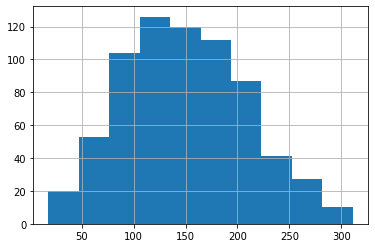

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 10)

In [ ]:
max_seq_len = 120

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights
<p> As we saw earlier that there is an unbalance between the classes of positive and negative labels. Lets handdel that using sklearn. This will change the cost for less found class more in comparison to more abundant one's thus balancing the training.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.86633663 1.18243243]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs, at start i tried 10 but saw that val loss was still decresing so changed it up to 25
epochs = 25

# Fine-Tune BERT
let's do the main things now!!

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 25

Evaluating...

Training Loss: 0.663
Validation Loss: 0.698

 Epoch 2 / 25

Evaluating...

Training Loss: 0.609
Validation Loss: 0.583

 Epoch 3 / 25

Evaluating...

Training Loss: 0.556
Validation Loss: 0.538

 Epoch 4 / 25

Evaluating...

Training Loss: 0.581
Validation Loss: 0.580

 Epoch 5 / 25

Evaluating...

Training Loss: 0.536
Validation Loss: 0.576

 Epoch 6 / 25

Evaluating...

Training Loss: 0.539
Validation Loss: 0.725

 Epoch 7 / 25

Evaluating...

Training Loss: 0.491
Validation Loss: 0.513

 Epoch 8 / 25

Evaluating...

Training Loss: 0.530
Validation Loss: 0.578

 Epoch 9 / 25

Evaluating...

Training Loss: 0.506
Validation Loss: 0.634

 Epoch 10 / 25

Evaluating...

Training Loss: 0.525
Validation Loss: 0.545

 Epoch 11 / 25

Evaluating...

Training Loss: 0.486
Validation Loss: 0.557

 Epoch 12 / 25

Evaluating...

Training Loss: 0.555
Validation Loss: 0.489

 Epoch 13 / 25

Evaluating...

Training Loss: 0.444
Validation Loss: 0.601

 Epoch 14 / 25

Eval

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87        87
           1       0.81      0.83      0.82        63

    accuracy                           0.85       150
   macro avg       0.84      0.84      0.84       150
weighted avg       0.85      0.85      0.85       150



In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,75,12
1,11,52


#Conclusion
<p>So here we can see that even the dataset of 1000 examples was able to achieve a f1 score of 0.85. This is the power of transfer learning possible via transformer architecture. We can also check at exactly what size of train set the score reaches ~0.9 by trying out a few numbers.